# Web Scraping

In [5]:
# What you've seen before
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

# What's new
from bs4 import BeautifulSoup # We'll be using this to scrape through HTML documents
import re # We'll be using regular expressions (a bit) to search through text
import networkx as nx # We'll be using this to graph a website (not super important)

## Example 1: Hacker News

In [6]:
html_doc = requests.get('https://news.ycombinator.com/').text
html_doc

'<html op="news"><head><meta name="referrer" content="origin"><meta name="viewport" content="width=device-width, initial-scale=1.0"><link rel="stylesheet" type="text/css" href="news.css?543QKAqoJKX29blpuDlq">\n        <link rel="shortcut icon" href="favicon.ico">\n          <link rel="alternate" type="application/rss+xml" title="RSS" href="rss">\n        <title>Hacker News</title></head><body><center><table id="hnmain" border="0" cellpadding="0" cellspacing="0" width="85%" bgcolor="#f6f6ef">\n        <tr><td bgcolor="#ff6600"><table border="0" cellpadding="0" cellspacing="0" width="100%" style="padding:2px"><tr><td style="width:18px;padding-right:4px"><a href="https://news.ycombinator.com"><img src="y18.gif" width="18" height="18" style="border:1px white solid;"></a></td>\n                  <td style="line-height:12pt; height:10px;"><span class="pagetop"><b class="hnname"><a href="news">Hacker News</a></b>\n              <a href="newest">new</a> | <a href="newcomments">comments</a> | <

### Basic Document Information

In [7]:
soup = BeautifulSoup(html_doc, "html5lib")
print(soup.title) # Find the 'title' tag
print(soup.title.string) # Find the 'title' tag's text value

<title>Hacker News</title>
Hacker News


In [8]:
# We can get all the text from elements in the HTML
# to get an easy dataset for the webpage's text content
print(soup.get_text())


        
          
        Hacker News
        
                  Hacker News
              new | comments | show | ask | jobs | submit            
                              login
                          
              

              
      1.      Please take care of my plant (pleasetakecareofmyplant.com)
        178 points by mooreds 2 hours ago  | hide | 22 comments              
      
                
      2.      A Little Story About the `yes` Unix Command (matthias-endler.de)
        28 points by omn1 40 minutes ago  | hide | 7 comments              
      
                
      3.      Beijing Pushes for a Direct Hand in Big Chinese Tech Firms (wsj.com)
        32 points by petethomas 1 hour ago  | hide | 16 comments              
      
                
      4.      Competitive Self-Play (openai.com)
        216 points by gdb 6 hours ago  | hide | 77 comments              
      
                
      5.      Firefox Send: Private, Encrypted File Sharing (firefox.

In [9]:
print(soup.a) # This gives us the first link ('a') tag in the document

# We can also iterate over all the link tags in a document
for link in soup.find_all('a'):
    print(link.get('href'))

<a href="https://news.ycombinator.com"><img height="18" src="y18.gif" style="border:1px white solid;" width="18"/></a>
https://news.ycombinator.com
news
newest
newcomments
show
ask
jobs
submit
login?goto=news
vote?id=15453974&how=up&goto=news
http://www.pleasetakecareofmyplant.com/
from?site=pleasetakecareofmyplant.com
user?id=mooreds
item?id=15453974
hide?id=15453974&goto=news
item?id=15453974
vote?id=15454352&how=up&goto=news
https://matthias-endler.de/2017/yes/
from?site=matthias-endler.de
user?id=omn1
item?id=15454352
hide?id=15454352&goto=news
item?id=15454352
vote?id=15454252&how=up&goto=news
https://www.wsj.com/articles/beijing-pushes-for-a-direct-hand-in-chinas-big-tech-firms-1507758314
from?site=wsj.com
user?id=petethomas
item?id=15454252
hide?id=15454252&goto=news
item?id=15454252
vote?id=15451584&how=up&goto=news
https://blog.openai.com/competitive-self-play/?
from?site=openai.com
user?id=gdb
item?id=15451584
hide?id=15451584&goto=news
item?id=15451584
vote?id=15448996&how=u

In [26]:
# Suppose we know the class of an element we want to search for.
# We can pass that in as a parameter to narrow our search
for story_link in soup.find_all('a', {'class': 'storylink'}):
    print(story_link.text)

Please take care of my plant
A Little Story About the `yes` Unix Command
Beijing Pushes for a Direct Hand in Big Chinese Tech Firms
Competitive Self-Play
Firefox Send: Private, Encrypted File Sharing
Ansible open-sources Ansible Tower with AWX
Symantec CEO says source code reviews by foreign states pose unacceptable risk
Why Stanford Researchers Tried to Create a ‘Gaydar’ Machine
Evidence That Online Dating Is Changing Society
Western news about China depends on intrepid Chinese ‘news assistants’
The Depression Thing
HelloSign Is Hiring Engineers (Elixir or PHP) (San Francisco)
Scientists Can Read a Bird’s Brain and Predict Its Next Song
RIP the Broccoli Tree
Functor-Oriented Programming
An algebraic generalization for graph and tensor-based neural networks [pdf]
What's killing us?
Ask HN: What non-work task have you automated?
The Ainu, the Indigenous people of Japan
Broken packets: IP fragmentation is flawed
Virtual Machine Warmup Blows Hot and Cold
Dropbox taking entire building in 

In [11]:
stories = []
for news_row in soup.find_all('tr', {'class': 'athing'}):
    # We can use the same commands on children nodes of the document
    # (.find() returns the first found result)
    story = news_row.find('a', {'class': 'storylink'})
    story_name, story_link = story.text, story.get('href')

    # We're not restricted just to searching up and down the document,
    # We can search accross 'siblings'
    meta_data_row = news_row.find_next_sibling('tr')
    
    score, comments = None, None
    
    # Need to check if the story has a score
    if meta_data_row.find('span', {'class': 'score'}):
        score = int(meta_data_row.find('span', {'class': 'score'}).text.split()[0])
    
    # If you know regular expressions, you can use those to search for patterns
    # in the document
    comments_pattern = re.compile(r'comments')
    if meta_data_row.find('a', text=comments_pattern):
        comments = int(meta_data_row.find('a', text=comments_pattern).text.split()[0])
    
    stories.append({
            'name': story_name,
            'link': story_link,
            'score': score,
            'comments': comments
        })

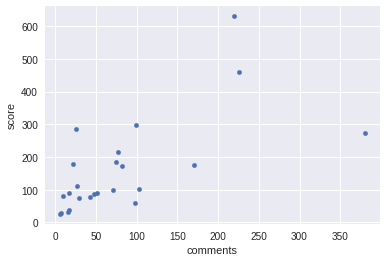

In [12]:
stories_df = pd.DataFrame(stories)
stories_df.plot.scatter('comments', 'score')

## Example 2: Crawling the Web

In [15]:
nyt_url = 'http://www.nytimes.com/'
nyt_links = {} # Dict to hold adjacent sites
links_to_scrape = [nyt_url] # Stack of links to visit

# Keep going while we still have links to visit, and we have
# 'seen' less than 1500 (unique) links
while links_to_scrape and len(nyt_links) < 600:
    # Grab the 'latest' link from our list
    scrape_page = links_to_scrape.pop()
    # Visit our link and make it into soup
    try:
        r = requests.get(scrape_page, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) Gecko/20100101 Firefox/47.0 Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv:42.0) Gecko/20100101 Firefox/42.0'})
    except:
        continue
    soup = BeautifulSoup(r.text, "html5lib")
    
    # Iterate through all the links on the current page
    for link in soup.find_all('a'):
        try: 
            href = link.get('href') # Get the link's address
        except requests.exceptions.ConnectionError:
            print("Connection refused by the server..")
            print("Let me sleep for 5 seconds")
            print("ZZzzzz...")
            time.sleep(5)
            print("Was a nice sleep, now let me continue...")
            continue

        # Reject the link if invalid or doesn't start with 'http'
        if not href or not href.startswith('http'):
            continue
            
        # Have we already visited this link?
        if not href in nyt_links:
            nyt_links[href] = [scrape_page] # Initialize list of adjacent links
            
            # Save link to scrape later
            if href not in links_to_scrape:
                links_to_scrape.append(href)
        else:
            nyt_links[href].append(scrape_page) # Add link to adjacent links
            
    # Report how many links we've 'seen'
    print("Up to {} links.".format(len(nyt_links)))

print(nyt_links)

Up to 255 links.
Up to 315 links.
Up to 335 links.
Up to 346 links.
Up to 513 links.
Up to 521 links.
Up to 527 links.
Up to 529 links.
Up to 541 links.
Up to 554 links.
Up to 565 links.
Up to 588 links.
Up to 626 links.
{'http://www.nytimes.com/content/help/site/ie9-support.html': ['http://www.nytimes.com/', 'http://www.nytimes.com/learning/general/feedback/index.html'], 'http://cn.nytimes.com': ['http://www.nytimes.com/'], 'https://www.nytimes.com/es/': ['http://www.nytimes.com/'], 'https://www.nytimes.com/': ['http://www.nytimes.com/', 'http://www.nytimes.com/', 'http://www.nytimes.com/', 'http://www.nytimes.com/learning/general/feedback/index.html', 'http://www.nytimes.com/learning/general/feedback/index.html', 'http://www.nytimes.com/learning/general/feedback/index.html'], 'http://www.nytimes.com/pages/todayspaper/index.html': ['http://www.nytimes.com/', 'https://www.nytimes.com/rss', 'http://homedelivery.nytimes.com'], 'https://www.nytimes.com/video': ['http://www.nytimes.com/', 

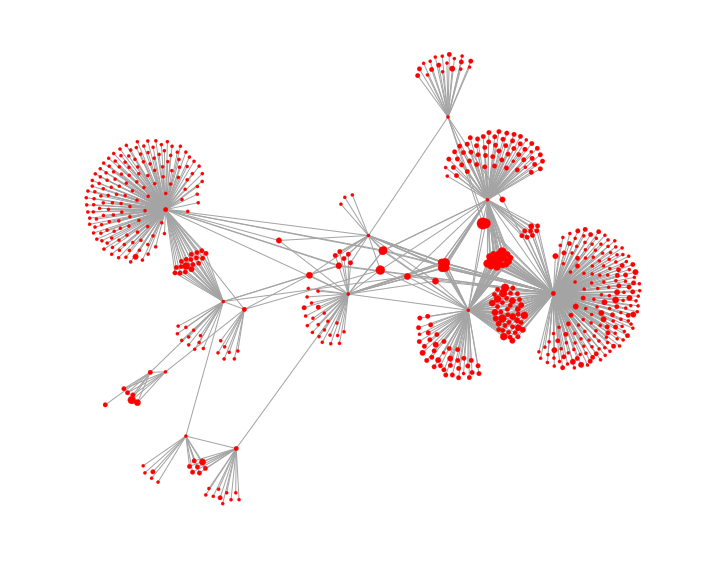

In [16]:
# Plotting the graph (not super important to know in detail)

# Create a graph and feed it in our pages as nodes
nyt_graph = nx.Graph()
nyt_graph.add_nodes_from(nyt_links.keys())

# Add edges based on the 'adjacent' lists we created earlier
for node, adjacent in nyt_links.items():
    for a in adjacent:
        nyt_graph.add_edge(node, a)

with sns.axes_style('white'):
    fig = plt.subplots(1, figsize=(12,10))
    nx.draw_networkx(nyt_graph, edge_color='#a4a4a4', with_labels=False,
                     node_size=list(map(lambda x: len(x) * 10, nyt_links.values())))
    plt.axis('off')

# Challenges
#### These may take you a bit longer! 😉

## Challenge 1: Subreddit Scraper
Write a function that, given the name of a subreddit, will return you a DataFrame with the same data that we scraped from the HackerNews news page. (Story name / link, Score, and # of comments).

(i.e. `subreddit_scraper('dataisbeautiful')` would be the function call)

**NOTE**: You may want to use this in your request: `headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'}`

In [38]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'}
html_doc = requests.get('https://www.reddit.com/r/UIUC/comments/1otmqs/who_is_the_hottest_professor_on_campus/',headers=headers).text
html_doc

T = []

soup = BeautifulSoup(html_doc, "html5lib")
for t in soup.find_all('time'):
     T.append(t.text)

#handsome = "https://www.reddit.com/r/UIUC/comments/1otmqs/who_is_the_hottest_professor_on_campus/"    
#subreddit_scraper(handsome)

In [39]:
T

['20 Oct 2013',
 '9 years',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago',
 '3 years ago']

## Challenge 2: PyPI Parser
*(PyPI is the indexer of popular python packages)*

Write a function that, given the URL of a Python package, will return you a dictionary with the following package information:
- Author
- Release (upload) Date
- License
- Home Page

(Note the possibility that not all of these fields will be present on all packages, and write your function accordingly)

In [ ]:
def pypi_parser(pypi_url):
    pass

pypi_parser('https://pypi.python.org/pypi/beautifulsoup4/4.5.1')
pypi_parser('https://pypi.python.org/pypi/SQLAlchemy/1.1.0')

## Challenge 3: IMDB Cast Data
Write a function that, given the URL of a movie on IMDB will return you a list of the cast of the movie with the following information:
- Actor name
- Character name
- Actor birthday

Example:
```
>>> imdb_cast('http://www.imdb.com/title/tt0796366/')
[
  {'actor': 'Chris Pine',
  'character': 'Kirk',
  'birthday': 'August 26, 1980'
  }
  ...
]
```


In [ ]:
def imdb_cast(movie_url):
    pass
imdb_cast('http://www.imdb.com/title/tt0796366/')


<h2><center>That's it!</center></h2>
![nice_job](http://i.giphy.com/eoxomXXVL2S0E.gif)


### Bonus Points:
1. For problem 1, write another function that uses the output of your function to plot the # of comments against the score of the post. Also, include a linear trend line. (Hint: `numpy.polyfit`)
2. For problem 2, include an array of all the published versions of the package in your return dictionary.

*Important:* When you send us your solutions, let us know which (if any)
of the bonus problems you've attempted.